In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
STOPWORDS = set(stopwords.words('english'))

#sample Dataset

corpus=[
    "The quickbrown fox jumps over the lazy dog",
    "The dog barked loudly at the fox",
    "The fox was very quick and agile",
    "The dog chased the fox all day",
    "The lazy dog laid in the sun"


]

labels=[1,0,1,0,0] # Binary labels for sentiment

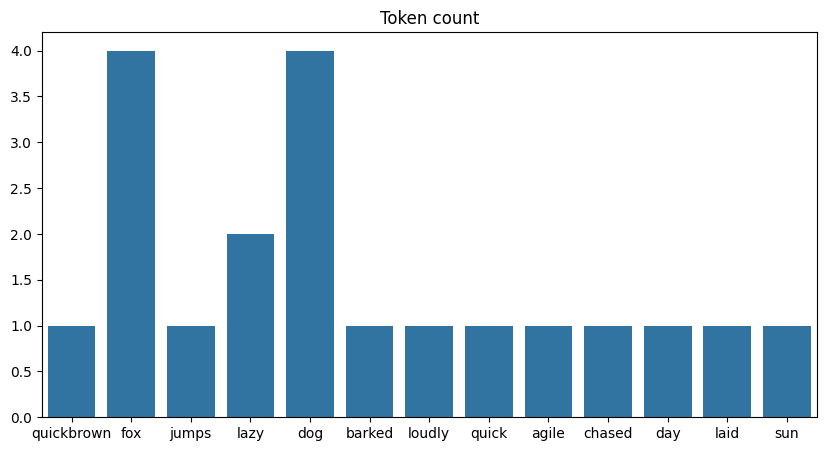

In [ ]:
def preprocess_text(text):
    text=text.lower()
    words=word_tokenize(text)
    words=[word for word in words if word.isalpha() and word not in STOPWORDS]
    return words

#apply preprocessing
preprocessed_corpus=[preprocess_text(doc) for doc in corpus]

#Token count visulazation
all_tokens=[token for doc in preprocessed_corpus for token in doc]
token_counts= Counter(all_tokens)

plt.figure(figsize=(10,5))
sns.barplot(x=list(token_counts.keys()),y=list(token_counts.values()))
plt.title('Token count')
plt.show()

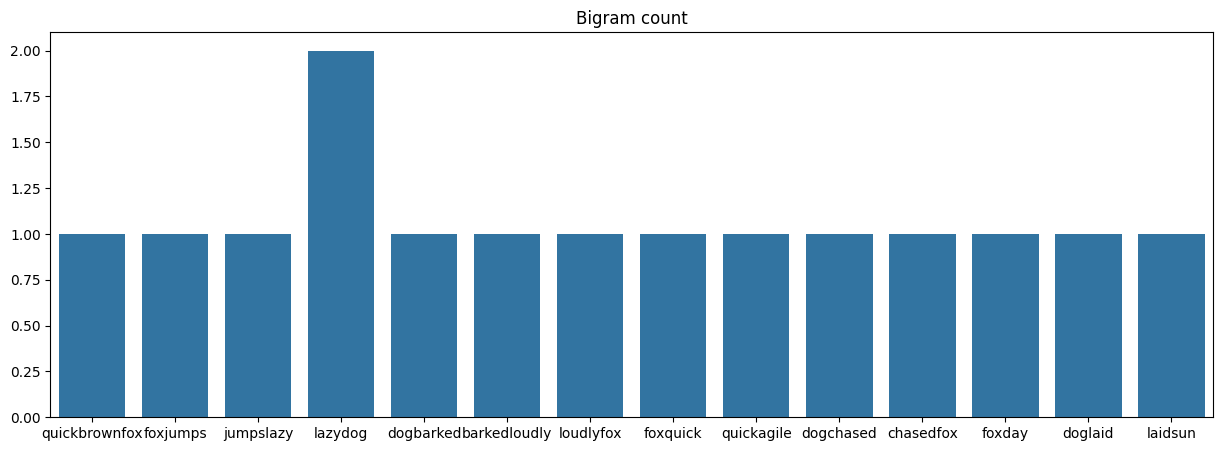

In [ ]:
#Genrate Bigram
bigram=[list(ngrams(docs,2)) for  docs in preprocessed_corpus]
bigram_counts=Counter(bg for doc in bigram for bg in doc)


#plot bogram counter
plt.figure(figsize=(15,5))
sns.barplot(x=["".join(bg) for bg in bigram_counts.keys()],y=list(bigram_counts.values()))
plt.title('Bigram count')
plt.show()

In [ ]:
!pip install requests
import requests
import zipfile
import os

In [ ]:
url='http://nlp.stanford.edu/data/glove.6B.zip'
glove_path='glove.6B.zip'

#download the file
print('Downloading GloVe embeddings...')
response=requests.get(url)
with open(glove_path,'wb') as f:
    f.write(response.content)

print('download complete')



#step extract   glove6b.50d
with zipfile.ZipFile(glove_path,'r') as zip_ref:
    zip_ref.extractall()

print('Extraction complete')

#clean up by removing the zip file
os.remove(glove_path)
print("clean up complete. Glove file ready to use ")




download complete
Extraction complete
clean up complete. Glove file ready to use 


Found 400000 word vectors


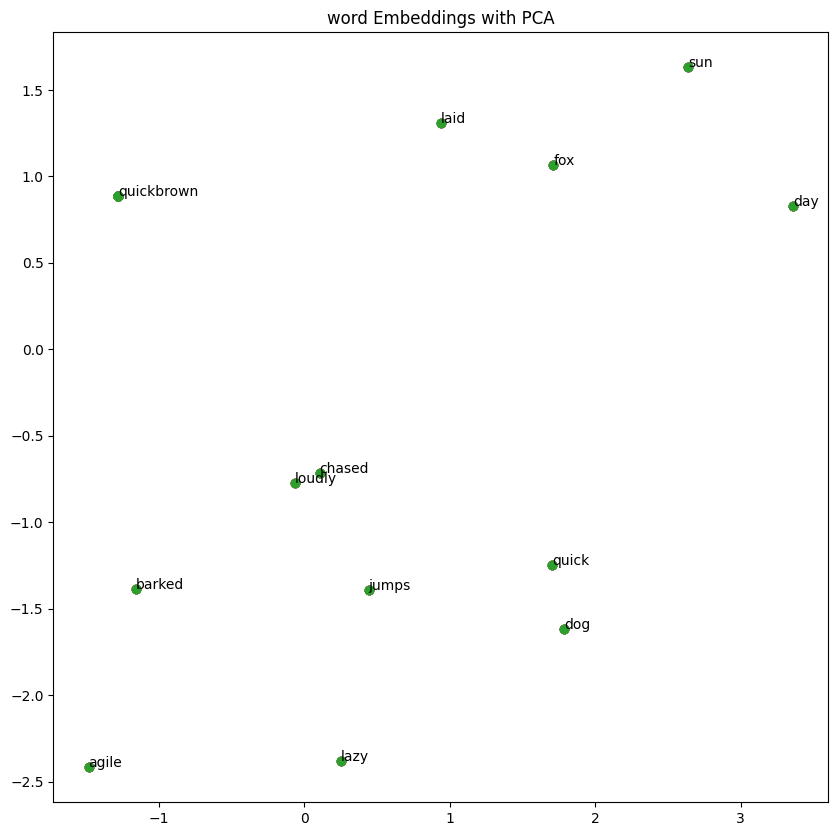

In [ ]:
#Load glove embedding
embeddings_index={}
with open('glove.6B.50d.txt','r',encoding='utf-8') as f:
  for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs

print(f'Found {len(embeddings_index)} word vectors')

#Get embedding for words in croups
embedding_dim=50
corups_vocab=list(set(all_tokens))
embedding_matrix=np.zeros((len(all_tokens),embedding_dim))


for i,word in enumerate(corups_vocab):
  embedding_vector=embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector

#PCA for 2D visu
pca=PCA(n_components=2)
reduced_embedding=pca.fit_transform(embedding_matrix)
#plot embedding
plt.figure(figsize=(10,10))
for i,word in enumerate(corups_vocab):
  plt.scatter(reduced_embedding[:,0],reduced_embedding[:,1])
  plt.annotate(word,(reduced_embedding[i,0],reduced_embedding[i,1]))

plt.title('word Embeddings with PCA')
plt.show()

<Axes: >

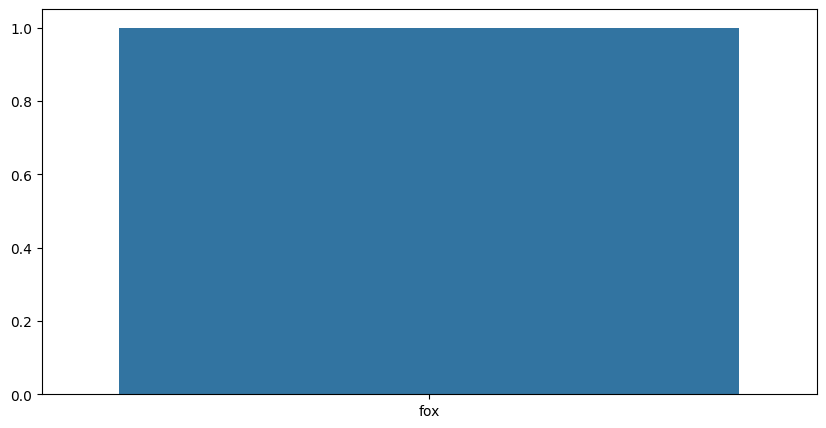

In [ ]:
# Bigram language model
bigram_model = {}
for doc in bigram:
  for w1, w2 in doc:
    if w1 not in bigram_model:
      bigram_model [w1] = Counter()
    bigram_model [w1] [w2] += 1


#normlize proba
for w1 in bigram_model:
  total_count = sum(bigram_model [w1].values())
  for w2 in bigram_model [w1]:
    bigram_model [w1] [w2] /= total_count


#visu bigram proba
word='chased'
word_probs = bigram_model [word]
plt.figure(figsize=(10,5))
sns.barplot(x=list(word_probs.keys()), y=list(word_probs.values()))

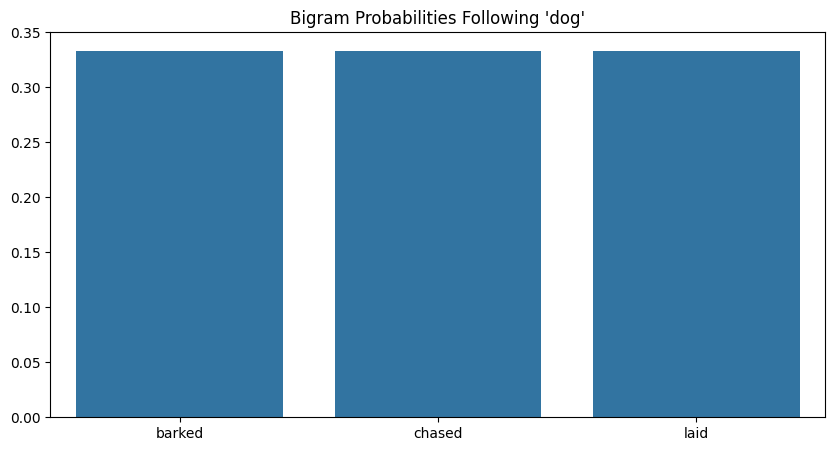

In [ ]:
# Visualize bigram probabilities for a specific word
word ="dog"
if word in bigram_model:
  word_probs = bigram_model [word]
  plt.figure(figsize=(10,5))
  sns.barplot(x=list(word_probs.keys()), y=list(word_probs.values()))
  plt.title(f"Bigram Probabilities Following '{word}'")
  plt.show()
else:
  print (f"The word '{word}' is not found as a bigram key.")


In [ ]:
all_tokens = [word for doc in preprocessed_corpus for word in doc]
corpus_vocab = list(set(all_tokens))
# Tokenization for LSTM model
vocab ={word: i+1 for i, word in enumerate (corpus_vocab)}
# +1 for padding index
tokenized_texts = [[vocab [word] for word in doc if word in vocab] for doc in preprocessed_corpus]
#Pad sequences
max_len = max(len(seq) for seq in tokenized_texts)
x= np.array([seq + [0] * (max_len - len(seq)) for seq in tokenized_texts])
y = np.array (labels)
# Define LSTM model
class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    # Call the superclass's __init__ method, not _init_
    super(SentimentLSTM, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
  def forward(self, x):
    x = self.embedding(x)
    lstm_out, _ = self.lstm(x) #added _ here since .lstm returns hidden and cell state
    out = self.fc(lstm_out[:, -1, :]) # Predict based on final hidden state
    return out
# Model training
model =SentimentLSTM (vocab_size=len (vocab) + 1, embedding_dim=embedding_dim, hidden_dim=50, output_dim=2)
criterion= nn. CrossEntropyLoss()
optimizer = optim.Adam (model.parameters(), lr=0.001)

In [ ]:
#Prepare data loader
class TextDataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.LongTensor(x)
    self.y = torch.LongTensor(y)
  def __getitem__(self, index):
    return self.x[index], self.y[index]
  def __len__(self):
    return len(self.y)

train_loader = DataLoader(TextDataset(x, y), batch_size=2, shuffle=True)
#trainning loop with visu
for epoch in range(10):
  total_loss=0
  for input,labels in train_loader:
    optimizer.zero_grad()
    output=model(input)
    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
  print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')


#visu lstm
model.eval()
with torch.no_grad():
  sample_input=torch.LongTensor(x[:1])
  lstm_output=model(sample_input)
  _, predicted_labels=torch.max(lstm_output,dim=1)
  print(predicted_labels.item())


Epoch 1, Loss: 0.048508428037166595
Epoch 2, Loss: 0.04318154603242874
Epoch 3, Loss: 0.03848864138126373
Epoch 4, Loss: 0.034362006932497025
Epoch 5, Loss: 0.03073837235569954
Epoch 6, Loss: 0.02755926176905632
Epoch 7, Loss: 0.024771610274910927
Epoch 8, Loss: 0.022327346727252007
Epoch 9, Loss: 0.02018352970480919
Epoch 10, Loss: 0.01830185577273369
0
